In [1]:
!pip install shap catboost scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import urllib
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
from skimage.transform import resize # if this line fails, try restarting the kernel
import matplotlib.pyplot as plt
%matplotlib inline

# load imagenet class names
import requests
response = requests.get('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json')
class_labels = {int(key): value for key, (code, value) in response.json().items()}

In [3]:
device

'cuda'

### Step I: manual explanation with smoothgrad

Let us begin by implementing our own little explainer for [DenseNet121](https://arxiv.org/abs/1608.06993) pretrained on ImageNet.

For the sake of simplicity, we're gonna rely on [SmoothGrad](https://arxiv.org/pdf/1706.03825.pdf) explainer - a simple average of gradients over noisy inputs.

In [4]:
# model = torchvision.models.densenet121(pretrained=True).train(False).to(device)
model = torchvision.models.resnet50(pretrained=True).train(False).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


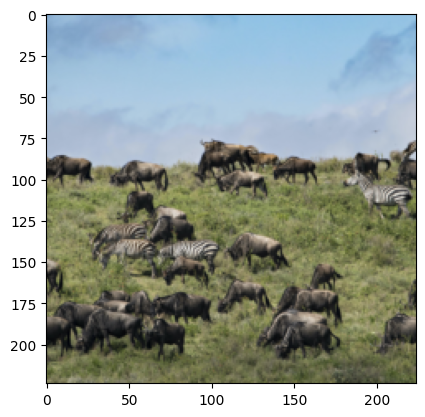

#1: p=0.723	zebra (340)
#2: p=0.043	warthog (343)
#3: p=0.042	water_buffalo (346)


In [8]:
!wget -q https://cdn.shopify.com/s/files/1/0069/4455/5061/articles/AdobeStock_165623749_1100x.jpg?v=1618956311 -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:3]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")

Now let's implement SmoothGrad itself.

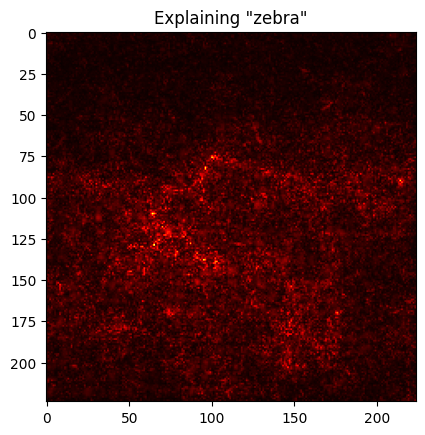

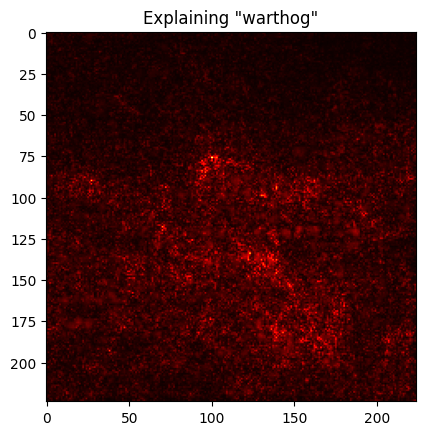

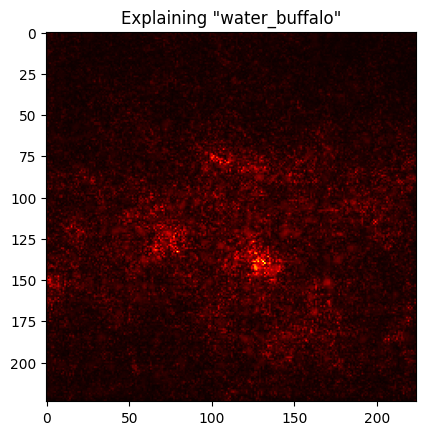

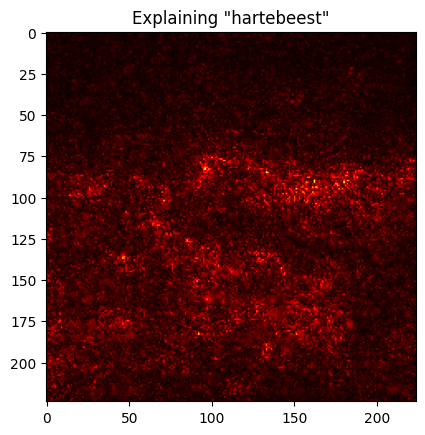

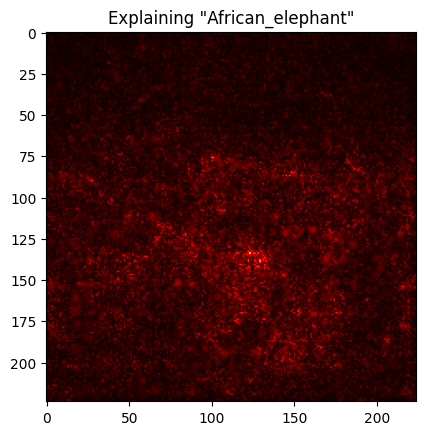

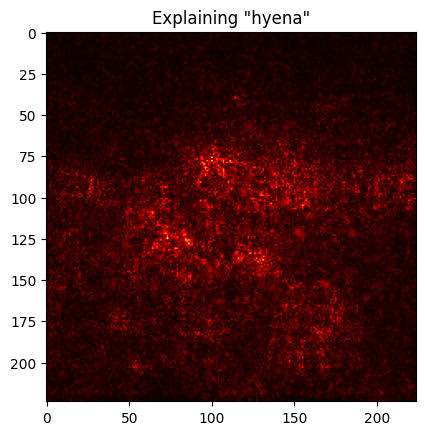

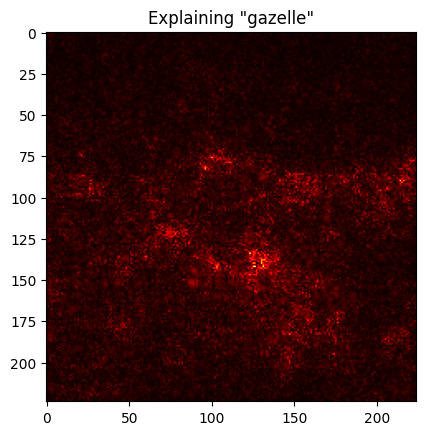

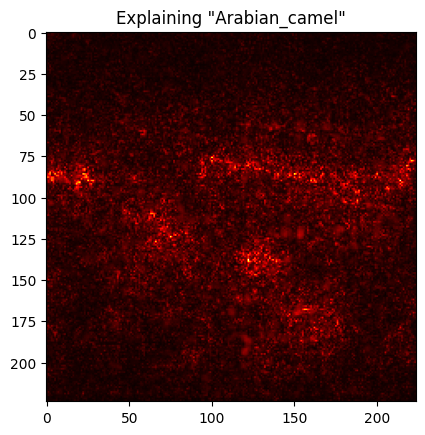

In [9]:
def explain_smoothgrad(image, class_ix, num_runs=4, sigma=0.1):
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2).requires_grad_(True)
    
    # repeat image tensor several times, add different noise to each copy
    repeated_image = image_tensor.repeat(num_runs, 1, 1, 1)
    noisy_images = repeated_image + sigma * torch.randn_like(repeated_image)
    
    class_scores = model(noisy_images)[:, class_ix]
    class_scores.sum().backward()  # backpropagate to image_tensor
    return abs(image_tensor.grad).mean(dim=1)[0].cpu().numpy()

for i, class_ix in enumerate(probs.argsort(descending=True)[:8]):
    plt.title(f'Explaining "{class_labels[int(class_ix.detach().cpu().numpy())]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='hot')
    plt.show()

__Bonus round!__ Peter Higgs nobel prize photo

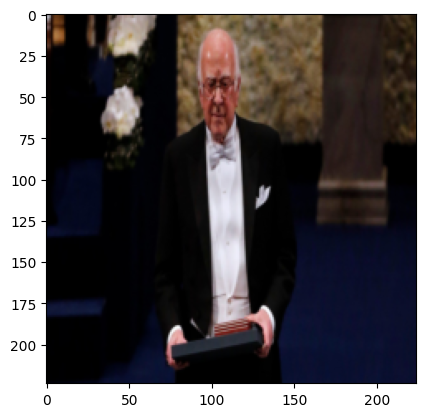

#1: p=0.210	suit (834)
#2: p=0.049	toilet_seat (861)
#3: p=0.039	plunger (731)
#4: p=0.032	vacuum (882)
#5: p=0.026	guillotine (583)
#6: p=0.024	balance_beam (416)
#7: p=0.023	academic_gown (400)
#8: p=0.021	torch (862)
#9: p=0.019	lab_coat (617)
#10: p=0.017	hook (600)


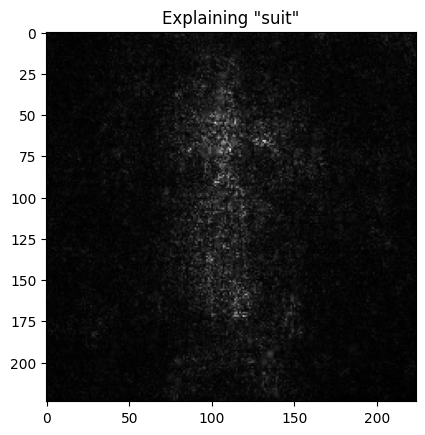

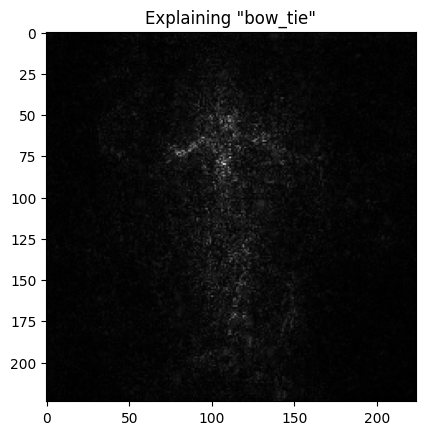

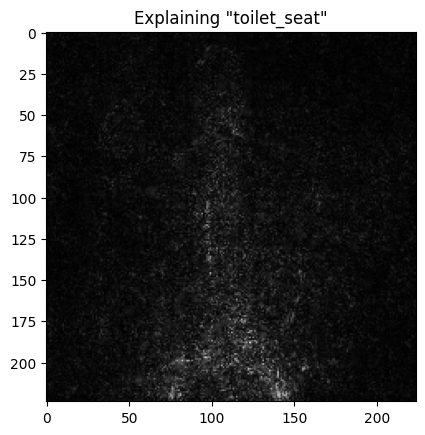

In [10]:
!wget -q https://i.pinimg.com/originals/3a/e1/83/3ae18369ab2e86be83e637ad702ec832.jpg -O img.jpg

image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
plt.imshow(image)
plt.show()

with torch.no_grad():
    image_tensor = torch.as_tensor(image, device=device, dtype=torch.float32)
    image_tensor = image_tensor[None].permute(0, 3, 1, 2)
    probs = torch.softmax(model(image_tensor), dim=-1)[0]
    
for i, class_ix in enumerate(probs.argsort(descending=True)[:10]):
    print(f"#{i + 1}: p={probs[class_ix].item():.3f}\t{class_labels[class_ix.item()]} ({class_ix.item()})")
    
for class_ix in 834, 457, 861:
    plt.title(f'Explaining "{class_labels[class_ix]}"')
    plt.imshow(explain_smoothgrad(image, class_ix), cmap='gray')
    plt.show()

### Part II: SHapley Additive exPlanations
Now, let's try something heavier. The current state of the art in explaining model predictions is [SHAP](https://arxiv.org/abs/1705.07874): Shapley Additive Explanations.

This method is based on [Shapley values](https://en.wikipedia.org/wiki/Shapley_value) - a game-theoretic concept that evaluates the contribution of individual players in a cooperative game. Except this time our "players" are input features and the "game" is predicting whichever output the model gave.

Computing Shapley values naively requires $O(F!)$ time where F is the number of features. To make this computation more feasible, authors [proposed](https://arxiv.org/abs/1705.07874) several approximations, one of which relies on averaged gradients. This approximation also requires "background" data - other images similar to the ones in question that can be used as reference points.

In [11]:
import shap # pip install shap
shap.initjs()

# load "background" images - some 50 random images from ImageNet
background, _ = shap.datasets.imagenet50()
background = torch.as_tensor(background / 255.0, device=device, dtype=torch.float32)
background = background.permute(0, 3, 1, 2)

In [12]:
# image to explain
!wget -q https://i.pinimg.com/originals/32/da/5c/32da5c3314fcc5ebf1a7b7d1548fcb03.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)

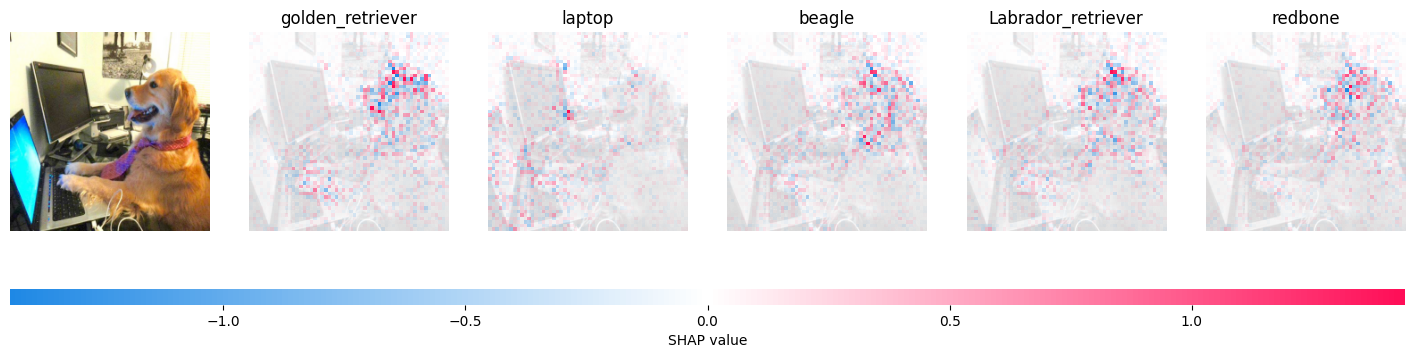

In [13]:
# explain and visualize. If you're not using GPU, this may take a minute or two.
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=5, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

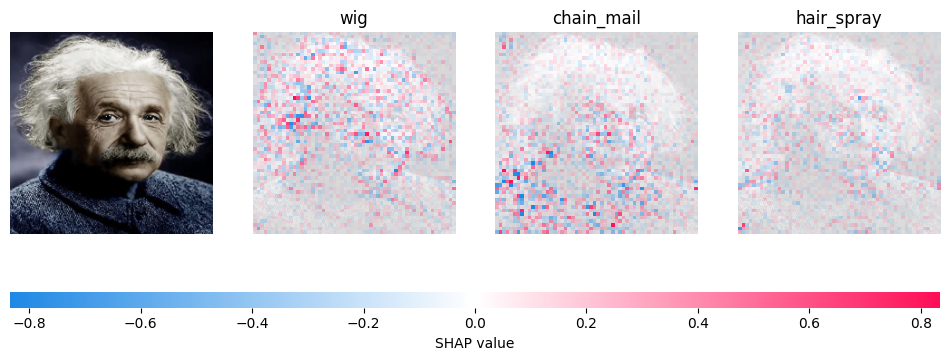

In [14]:
# obligatory physicist reference
!wget -q https://images-na.ssl-images-amazon.com/images/I/51ArQaCkkZL._AC_.jpg -O img.jpg
image = resize(plt.imread('img.jpg')[..., :3] / 255.0, (224, 224))
image_tensor = torch.as_tensor(image[None], device=device, dtype=torch.float32).permute(0, 3, 1, 2)
explainer = shap.GradientExplainer((model, model.layer1), background)
shap_values, indices = explainer.shap_values(image_tensor, ranked_outputs=3, nsamples=200)
shap_values = [np.transpose(values, (0, 2, 3, 1)) for values in shap_values]
index_names = np.vectorize(lambda i: class_labels[i])(indices.cpu().numpy())
shap.image_plot(shap_values, image_tensor.permute(0, 2, 3, 1).cpu().numpy(), index_names)

### Part III: explaining classical machine learning models

Finally, let's see how SHAP explainers can be applied to more conventional machine learning models like gradient boosting. 

Spoiler: exactly the same from a user's perspective. However, this time we're gonna use a different Shapley approximation implemented in TreeExplainer. For a full set of available explainers, take a look at their official [examples page](https://github.com/slundberg/shap/tree/master/notebooks).

In [15]:
import catboost # pip install catboost
import pandas as pd

shap.initjs()

# And here we come to the fairness in AI
# Good thing we deal with particles, not people
X, y = shap.datasets.boston()
# data_url = "http://lib.stat.cmu.edu/datasets/boston"
# raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
# X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
# Question of the day: why so covoluted preprocessing?
y = raw_df.values[1::2, 2]
X_pd = pd.DataFrame(data=X, columns=
                    ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE",
                     "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"])
ensemble = catboost.CatBoostRegressor(iterations=100, learning_rate=0.1)
ensemble.fit(X, y, verbose=False, plot=False)
explainer = shap.TreeExplainer(ensemble)
shap_values = explainer.shap_values(X_pd)

# visualize explanation of the first example
# (note: this visualization only works in regular jupyter!)
example_idex = 0
shap.force_plot(explainer.expected_value, shap_values[example_idex, :],
                X_pd.iloc[example_idex])

ImportError: ignored

```
 CRIM     per capita crime rate by town
 ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
 INDUS    proportion of non-retail business acres per town
 CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
 NOX      nitric oxides concentration (parts per 10 million)
 RM       average number of rooms per dwelling
 AGE      proportion of owner-occupied units built prior to 1940
 DIS      weighted distances to five Boston employment centres
 RAD      index of accessibility to radial highways
 TAX      full-value property-tax rate per $10,000
 PTRATIO  pupil-teacher ratio by town
 B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
 LSTAT    % lower status of the population
```



In [ ]:
# Explain training data: each *column* is a rotated plot from above, stacked for all training samples
# (this plot is interactive, hover mouse to see feature names)
# (note: this visualization only works in regular jupyter!)
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values, X)

## References:
* SHAP explainer based on superpixels - [notebook](https://slundberg.github.io/shap/notebooks/ImageNet%20VGG16%20Model%20with%20Keras.html)
* SHAP reference notebook - [view on github](https://github.com/slundberg/shap/tree/master/notebooks)
* More various explainers in [ELI5](https://github.com/TeamHG-Memex/eli5)